# Poisson Image Editing

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

In Poisson image editing, we want the gradient of the composite (source image + the target image) to be as close as possible to the source image gradient. We want our composite image to match the target image on the boudary. Thus, we want to minimise the difference between the gradient of the composite and source images subject to constraint that the image we create must agree with the target image on the boundary. To perform seamless cloning, we can either perform importing gradients (which will include boundary information) or mixing gradients (which will include information about the strongest gradients, allowing to preserve distinction of source vs target images).

## Implementation

To solve both the importing gradients and mixing gradients problems, we can set up a linear equation of the form Ax = c where A is a sparse matrix conisisting of 4s and -1s (representing the fact that we will be taking the laplacian of an image), x will be the flattened image of unknown intensities and c is a vector of intensities whose values will be based on the approach we take to solve the problem.

In [2]:
# A naive copy and paste of a source image onto a target image
# We will later compare results of this naive appraoch to the Poisson image editing approach 
def copy_and_paste(source_img, target_img, pos_x, pos_y):
    target_with_source = target_img.copy()
    source_height, source_width = source_img.shape
    target_with_source[pos_y:pos_y+source_height, pos_x:pos_x+source_width] = source_img
    return target_with_source

We will firstly create a sparse matrix A, which will be the same for both importing and mixing gradient methods.

In [3]:
# utility functions to generate sparse matrix
def in_bounds_row(i, num_rows):
    if i >= 0 and i < num_rows:
        return True

    return False

def in_bounds_column(j, num_columns):
    if j >= 0 and j < num_columns:
        return True
    
    return False

def in_bounds_row_col(i, j, num_rows, num_columns):
    return in_bounds_row(i, num_rows) and in_bounds_column(j, num_columns)

def generate_dict_map_for_laplacian(num_rows, num_columns):
    """
    Input: number of rows and number of columns of an image for which we want to generate the laplacian matrix
    Output: a map between (row, column) of the image which identifies the column position for which we
            set -1
    This is a helper function used to set up the laplacian matrix
    """
    mapping_for_laplacian = {}
    count = 0
    for row in range(num_rows):
        for col in range(num_columns):
            mapping_for_laplacian[(row, col)] = count
            count += 1

    return mapping_for_laplacian

In [4]:
def create_sparse_laplacian_matrix(num_rows, num_columns):
    """
    Input: number of rows and number of columns of an image for which we want to generate the laplacian matrix
    Output: a 2d numpy array representing the laplacian matrix
    """
    laplacian_map = generate_dict_map_for_laplacian(num_rows, num_columns)
    N = num_rows * num_columns
    laplacian_matrix = np.zeros((N, N))
    curr_row_laplacian = 0
    # iterate over each each pixel position and for each set the appropriate laplacian entry
    for row in range(num_rows):
        for col in range(num_columns):
            i, j = row, col
            up_i, up_j = i-1, j
            right_i, right_j = i, j+1
            down_i, down_j = i+1, j
            left_i, left_j = i, j-1

            # set the laplacian values for the ith row
            laplacian_matrix[curr_row_laplacian, laplacian_map[(i, j)]] = 4

            # set up to -1
            if in_bounds_row_col(up_i, up_j, num_rows, num_columns):
                laplacian_matrix[curr_row_laplacian, laplacian_map[(up_i, up_j)]] = -1

            # set right to -1
            if in_bounds_row_col(right_i, right_j, num_rows, num_columns):
                laplacian_matrix[curr_row_laplacian, laplacian_map[(right_i, right_j)]] = -1

            # set down to -1
            if in_bounds_row_col(down_i, down_j, num_rows, num_columns):
                laplacian_matrix[curr_row_laplacian, laplacian_map[(down_i, down_j)]] = -1

            # set left to -1
            if in_bounds_row_col(left_i, left_j, num_rows, num_columns):
                laplacian_matrix[curr_row_laplacian, laplacian_map[(left_i, left_j)]] = -1

            # set the laplacian values for the ith row
            laplacian_matrix[curr_row_laplacian, laplacian_map[(i, j)]] = 4

            curr_row_laplacian += 1
        
    return laplacian_matrix

We then create a function which returns a vector incorporating information about the target image gradients on the boundary (missing intensity gradients from the target image of the left hand side of the equation).

In [5]:
def create_target_vec_at_boundary(target_img, starting_x, starting_y, num_rows, num_columns):
    """
    Input: the target image, starting coordinates (x, y) of the target image in which a source image would be placed onto, 
           number of rows and columns of the source image
    Output: a vector incorporating information about gradients on the boundary of the target image 
    """
    target_vec = np.zeros((num_rows*num_columns,))
    source_height, source_width = num_rows, num_columns
    temp_img = np.zeros((num_rows, num_columns))
    # create an image which is useful for iterating over the appropriate indices
    naive_blended_img = copy_and_paste(temp_img, target_img, starting_x, starting_y)

    curr_pos = 0
    for y in range(starting_y, starting_y+source_height):
        for x in range(starting_x, starting_x+source_width):
            if (y == starting_y or y == starting_y+source_height-1 or x == starting_x or x == starting_x+source_width-1):
                # at the boundary
                if (x, y) == (starting_x, starting_y):
                    # leftmost top corner
                    up, left = (x, y-1), (x-1, y)
                    target_vec[curr_pos] = naive_blended_img[up[1], up[0]] + naive_blended_img[left[1], left[0]]
                elif (x, y) == (starting_x+source_width-1, starting_y):
                    # rightmost top corner
                    up, right = (x, y-1), (x+1, y)
                    target_vec[curr_pos] = naive_blended_img[up[1], up[0]] + naive_blended_img[right[1], right[0]]
                elif (x, y) == (starting_x+source_width-1, starting_y+source_height-1):
                    # rightmost bottom corner
                    down, right = (x, y+1), (x+1, y)
                    target_vec[curr_pos] = naive_blended_img[down[1], down[0]] + naive_blended_img[right[1], right[0]]
                elif (x, y) == (starting_x, starting_y+source_height-1):
                    # leftmost bottom corner
                    down, left = (x, y+1), (x-1, y)
                    target_vec[curr_pos] = naive_blended_img[down[1], down[0]] + naive_blended_img[left[1], left[0]]
                elif x == starting_x:
                    left = (x-1, y)
                    target_vec[curr_pos] = naive_blended_img[left[1], left[0]]
                elif x == starting_x+source_width-1:
                    right = (x+1, y)
                    target_vec[curr_pos] = naive_blended_img[right[1], right[0]]
                elif y == starting_y:
                    up = (x, y-1)
                    target_vec[curr_pos] = naive_blended_img[up[1], up[0]]
                elif y == starting_y+source_height-1:
                    down = (x, y+1)
                    target_vec[curr_pos] = naive_blended_img[down[1], down[0]]

            curr_pos+=1

    return target_vec

Here, we specifically implement the different approaches to Poisson editing: (1) importing gradients and (2) mixing gradients.

In [6]:
# utility function to compute laplacian at a point
def compute_laplacian(source, x, y):
    return 4*source[y, x] - source[y, x-1] - source[y, x+1] - source[y+1, x] - source[y-1, x]

We create a function which returns a vector incorporating the source image gradient information. Note this will be used with importing gradients.

In [7]:
def create_vec_b_for_importing_gradients(source):
    """
    Input: source image
    Output: vector incorporating information about the source image gradients
    """
    b = np.zeros((source.shape[0]-2)*(source.shape[1]-2))
    count = 0
    for row in range(1, source.shape[0]-1):
        for col in range(1, source.shape[1]-1):
            b[count] = compute_laplacian(source, col, row)
            count += 1

    return b

We create a function which returns a vector incorporating the source image gradient information as well as the target information, ensuring we take the strongest gradient along each direction for the divergence. Note this will be used with mixing gradients.

In [8]:
def create_vec_b_for_mixing_gradients(source, target, starting_x, starting_y):
    """
    Input: source image
    Output: vector incorporating information about the source and target image gradients -> divergence
    """
    b = np.zeros((source.shape[0]-2)*(source.shape[1]-2))
    # we know at the boundary, target and source gradients match, so we don't need to start at the original starting point
    target_subsection = target[starting_y:starting_y+source.shape[0], starting_x:starting_x+source.shape[1]]
    count = 0
    for row in range(1, source.shape[0]-1):
        for col in range(1, source.shape[1]-1):
            x, y = col, row
            curr_div = 0 # current divergence value, sum of strongest gradients (taken either from source or target images)

            left_target = target_subsection[y, x]-target_subsection[y, x-1]
            left_source = source[y, x]-source[y, x-1]
            if abs(left_target) > abs(left_source):
                curr_div += left_target
            else:
                curr_div += left_source

            up_target = target_subsection[y, x]-target_subsection[y-1, x]
            up_source = source[y, x]-source[y-1, x]
            if abs(up_target) > abs(up_source):
                curr_div += up_target
            else:
                curr_div += up_source

            right_target = target_subsection[y, x]-target_subsection[y, x+1]
            right_source = source[y, x]-source[y, x+1]
            if abs(right_target) > abs(right_source):
                curr_div += right_target
            else:
                curr_div += right_source

            down_target = target_subsection[y, x]-target_subsection[y+1, x]
            down_source = source[y, x]-source[y+1, x]
            if abs(down_target) > abs(down_source):
                curr_div += down_target
            else:
                curr_div += down_source

            # store the the current divergence at the appropriate index for the vector b
            b[count] = curr_div
            count+=1

    return b

Finally, we have functions that implement (1) importing gradients and (2) mixing gradients.

(1) We solve Ax = b + t, where A is our sparse matrix, b is the vector b for importing gradients (call create_vec_b_for_importing_gradients), and t is the vector of target image intensities on the boundary (call create_target_vec_at_boundary).

In [9]:
# (1) importing gradient
def importing_gradients(source, target, start_x, start_y, combine=False):
    """
    Input: source and target images, position (x, y) where source image is placed onto the target image, 
           a boolean 'combine' which can be set to either True or False
    Output: if 'combine' is set to True, returns the seamless cloning of the source image onto the target image
            using importing gradients, otherwise it just returns the resulting image from solving the equation Ax = c
            for importing gradients 
    """
    sparse_mat = create_sparse_laplacian_matrix(source.shape[0]-2, source.shape[1]-2)
    b_importing_gradients = create_vec_b_for_importing_gradients(source)
    t_importing_gradients = create_target_vec_at_boundary(target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    rhs = b_importing_gradients + t_importing_gradients
    x = np.linalg.solve(sparse_mat, rhs)
    res = x.reshape(source.shape[0]-2, source.shape[1]-2)
    if not(combine):
        return res
    else:
        res_combined = copy_and_paste(res, target, start_x+1, start_y+1)
        return res_combined

(2) We solve Ax = b + t, where A is our sparse matrix, b is the vector b for mixing gradients (call create_vec_b_for_mixing_gradients), and t is the vector of target image intensities on the boundary (call create_target_vec_at_boundary).

In [10]:
# (2) mixing gradient
def mixing_gradients(source, target, start_x, start_y, combine=False):
    """
    Input: source and target images, position (x, y) where source image is placed onto the target image, 
           a boolean 'combine' which can be set to either True or False
    Output: if 'combine' is set to True, returns the seamless cloning of the source image onto the target image
            using mixing gradients, otherwise it just returns the resulting image from solving the equation Ax = c
            for mixing gradients
    """
    sparse_mat = create_sparse_laplacian_matrix(source.shape[0]-2, source.shape[1]-2)
    b_mixing_gradients = create_vec_b_for_mixing_gradients(source, target, start_x, start_y)
    t_mixing_gradients = create_target_vec_at_boundary(target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    rhs = b_mixing_gradients + t_mixing_gradients
    x = np.linalg.solve(sparse_mat, rhs)
    res = x.reshape(source.shape[0]-2, source.shape[1]-2)
    if not(combine):
        return res
    else:
        res_combined = copy_and_paste(res, target, start_x+1, start_y+1)
        return res_combined

We also have the 'colour' versions of each of the previously implemented functions. They are implemented in a similar way except we work with 3 channels (red, green, blue).

In [11]:
def copy_and_paste_colour(source_img, target_img, pos_x, pos_y):
    target_with_source = target_img.copy()
    source_height, source_width, _ = source_img.shape
    target_with_source[pos_y:pos_y+source_height, pos_x:pos_x+source_width, :] = source_img
    return target_with_source

def colour_importing_gradients(source, target, start_x, start_y, combine=False):
    # this time we have colours images, we apply the importing gradient algorithm on all 3 channels
    red_channel_source = source[:, :, 0]
    red_channel_target = target[:, :, 0]
    green_channel_source = source[:, :, 1]
    green_channel_target = target[:, :, 1]
    blue_channel_source = source[:, :, 2]
    blue_channel_target = target[:, :, 2]

    sparse_mat = create_sparse_laplacian_matrix(source.shape[0]-2, source.shape[1]-2)
    
    b_red_importing_gradients = create_vec_b_for_importing_gradients(red_channel_source)
    b_green_importing_gradients = create_vec_b_for_importing_gradients(green_channel_source)
    b_blue_importing_gradients = create_vec_b_for_importing_gradients(blue_channel_source)
    
    t_red_importing_gradients = create_target_vec_at_boundary(red_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    t_green_importing_gradients = create_target_vec_at_boundary(green_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    t_blue_importing_gradients = create_target_vec_at_boundary(blue_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    
    rhs_red = b_red_importing_gradients+t_red_importing_gradients
    rhs_green = b_green_importing_gradients+t_green_importing_gradients
    rhs_blue = b_blue_importing_gradients+t_blue_importing_gradients
    
    x_red = np.linalg.solve(sparse_mat, rhs_red)
    x_green = np.linalg.solve(sparse_mat, rhs_green)
    x_blue = np.linalg.solve(sparse_mat, rhs_blue)

    res_red = x_red.reshape(source.shape[0]-2, source.shape[1]-2)
    res_green = x_green.reshape(source.shape[0]-2, source.shape[1]-2)
    res_blue = x_blue.reshape(source.shape[0]-2, source.shape[1]-2)

    res_colour = np.dstack((res_red, res_green, res_blue))
    res_colour[res_colour>1] = 1
    res_colour[res_colour<0] = 0

    if not(combine):
        return res_colour
    else:
        res_combined_colour = copy_and_paste_colour(res_colour, target, start_x+1, start_y+1)
        return res_combined_colour

def colour_mixing_gradients(source, target, start_x, start_y, combine=False):
    # this time we have colours images, we apply the mixing gradient algorithm on all 3 channels
    red_channel_source = source[:, :, 0]
    red_channel_target = target[:, :, 0]
    green_channel_source = source[:, :, 1]
    green_channel_target = target[:, :, 1]
    blue_channel_source = source[:, :, 2]
    blue_channel_target = target[:, :, 2]

    sparse_mat = create_sparse_laplacian_matrix(source.shape[0]-2, source.shape[1]-2)
    
    b_red_mixing_gradients = create_vec_b_for_mixing_gradients(red_channel_source, red_channel_target, start_x, start_y)
    b_green_mixing_gradients = create_vec_b_for_mixing_gradients(green_channel_source, green_channel_target, start_x, start_y)
    b_blue_mixing_gradients = create_vec_b_for_mixing_gradients(blue_channel_source, blue_channel_target, start_x, start_y)
    
    t_red_mixing_gradients = create_target_vec_at_boundary(red_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    t_green_mixing_gradients = create_target_vec_at_boundary(green_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    t_blue_mixing_gradients = create_target_vec_at_boundary(blue_channel_target, start_x+1, start_y+1, source.shape[0]-2, source.shape[1]-2)
    
    rhs_red = b_red_mixing_gradients+t_red_mixing_gradients
    rhs_green = b_green_mixing_gradients+t_green_mixing_gradients
    rhs_blue = b_blue_mixing_gradients+t_blue_mixing_gradients
    
    x_red = np.linalg.solve(sparse_mat, rhs_red)
    x_green = np.linalg.solve(sparse_mat, rhs_green)
    x_blue = np.linalg.solve(sparse_mat, rhs_blue)

    res_red = x_red.reshape(source.shape[0]-2, source.shape[1]-2)
    res_green = x_green.reshape(source.shape[0]-2, source.shape[1]-2)
    res_blue = x_blue.reshape(source.shape[0]-2, source.shape[1]-2)

    res_colour = np.dstack((res_red, res_green, res_blue))
    res_colour[res_colour>1] = 1
    res_colour[res_colour<0] = 0

    if not(combine):
        return res_colour
    else:
        res_combined_colour = copy_and_paste_colour(res_colour, target, start_x+1, start_y+1)
        return res_combined_colour    

## Analysis

We will be testing both the importing gradients and mixing gradients approaches on some examples images (grayscale and colour images) to see how they differ between each other and also how they contrast relative to the naive approach of copy and paste.

Load the grayscale images.

The shape of the source grayscale image is: (107, 150)


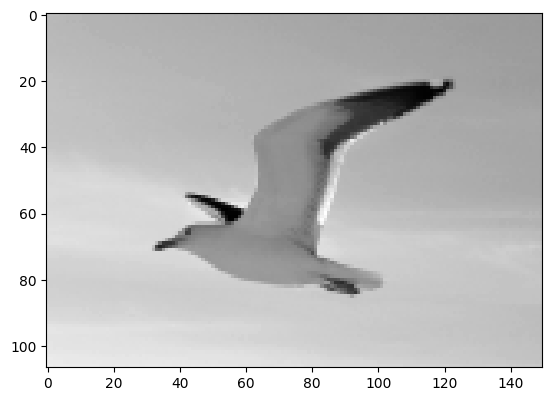

In [12]:
source_grayscale = mpimg.imread("images/source_grayscale.png")
print(f"The shape of the source grayscale image is: {source_grayscale.shape}")
plt.imshow(source_grayscale, cmap=plt.cm.gray)

The shape of the target grayscale image is: (665, 1000)


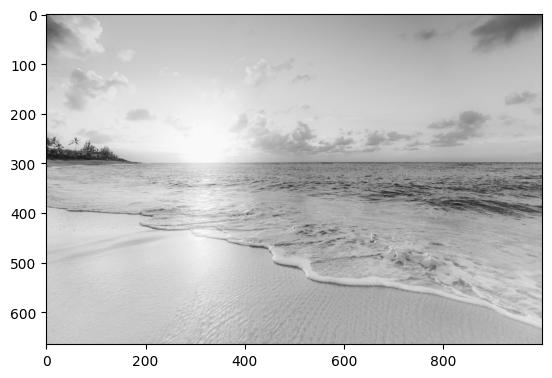

In [13]:
target_grayscale = mpimg.imread("images/target_grayscale.png")
print(f"The shape of the target grayscale image is: {target_grayscale.shape}")
plt.imshow(target_grayscale, cmap=plt.cm.gray)

We define the position (x, y) in the target image where we want to paste the source image.

In [14]:
# define starting x and starting y position of where we want to place the source image in the target image
START_X_FIRST = 600
START_Y_FIRST = 100

# we also define another starting position for which we can observe the result of mixing gradient more easily
START_X_SECOND = 400
START_Y_SECOND = 200

We observe results of the naive "copy and paste", "importing gradients" and "mixing gradients" approaches at position (START_X_FIRST, START_Y_FIRST).

In [15]:
res_naive1 = copy_and_paste(source_grayscale, target_grayscale, START_X_FIRST, START_Y_FIRST)
res_importing1 = importing_gradients(source_grayscale, target_grayscale, START_X_FIRST, START_Y_FIRST, combine=True)
res_mixing1 = mixing_gradients(source_grayscale, target_grayscale, START_X_FIRST, START_Y_FIRST, combine=True)

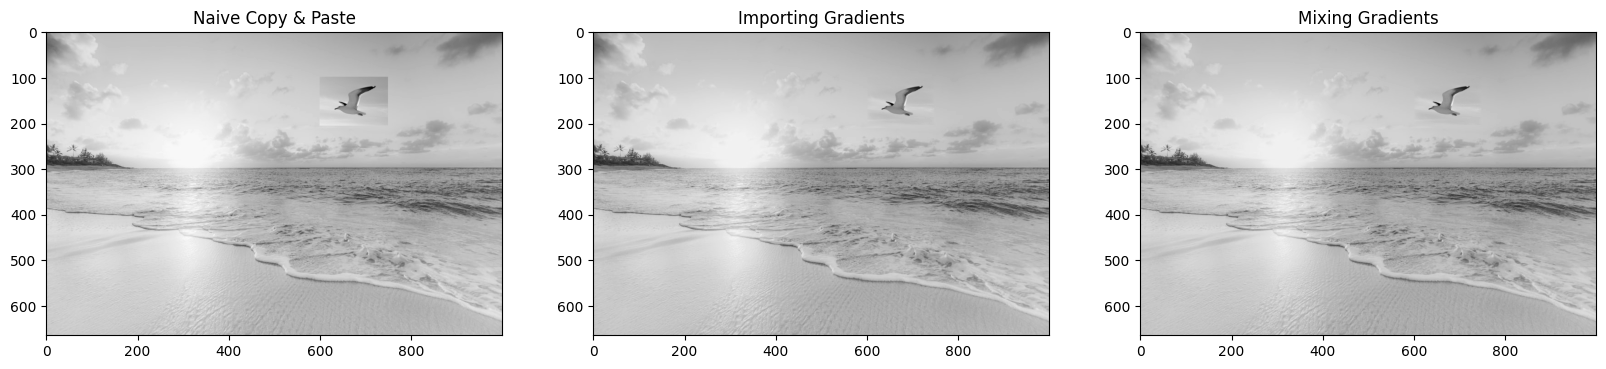

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(res_naive1, cmap=plt.cm.gray)
ax[1].imshow(res_importing1, cmap=plt.cm.gray)
ax[2].imshow(res_mixing1, cmap=plt.cm.gray)

ax[0].set_title('Naive Copy & Paste')
ax[1].set_title('Importing Gradients')
ax[2].set_title('Mixing Gradients')

plt.show()

We observe results of the naive "copy and paste", "importing gradients" and "mixing gradients" approaches at position (START_X_SECOND, START_Y_SECOND). Note, here we will be able to observe that there are some unwanted artifacts in the "importing gradients" approach as the source image is placed in a high-frequency region. The unwanted artifacts do not appear anymore once we use the "mixing gradients" approach. 

In [17]:
res_naive2 = copy_and_paste(source_grayscale, target_grayscale, START_X_SECOND, START_Y_SECOND)
res_importing2 = importing_gradients(source_grayscale, target_grayscale, START_X_SECOND, START_Y_SECOND, combine=True)
res_mixing2 = mixing_gradients(source_grayscale, target_grayscale, START_X_SECOND, START_Y_SECOND, combine=True)

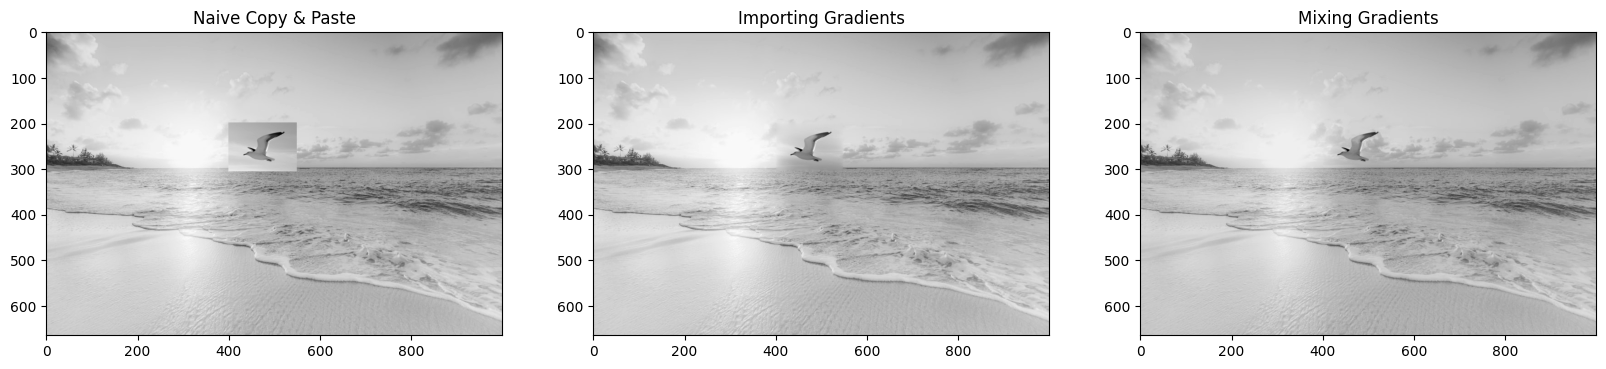

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(res_naive2, cmap=plt.cm.gray)
ax[1].imshow(res_importing2, cmap=plt.cm.gray)
ax[2].imshow(res_mixing2, cmap=plt.cm.gray)

ax[0].set_title('Naive Copy & Paste')
ax[1].set_title('Importing Gradients')
ax[2].set_title('Mixing Gradients')

plt.show()

Similar results can be observed for colour images.

Load the colour images.

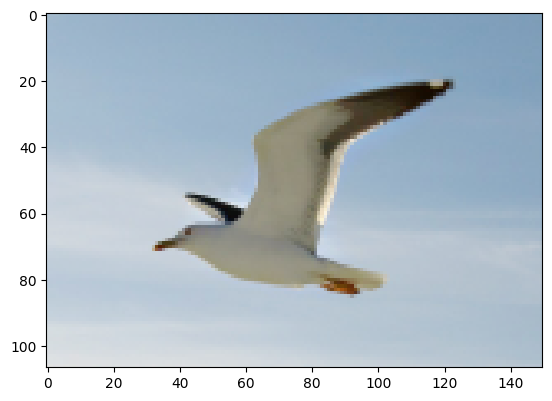

In [19]:
source_colour = mpimg.imread("images/source_colour.png")
# discard alpha channel
source_colour = source_colour[:, :, :3]
plt.imshow(source_colour)

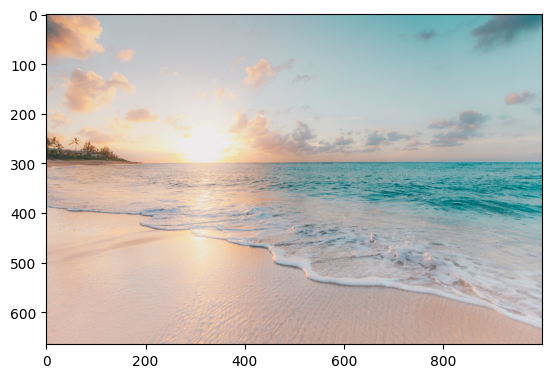

In [20]:
target_colour = mpimg.imread("images/target_colour.png")
plt.imshow(target_colour)

We observe results of the naive "copy and paste", "importing gradients" and "mixing gradients" approaches at position (START_X_SECOND, START_Y_SECOND) for colour images.

In [22]:
res_naive_colour = copy_and_paste_colour(source_colour, target_colour, START_X_SECOND, START_Y_SECOND)
res_importing_colour = colour_importing_gradients(source_colour, target_colour, START_X_SECOND, START_Y_SECOND, combine=True)
res_mixing_colour = colour_mixing_gradients(source_colour, target_colour, START_X_SECOND, START_Y_SECOND, combine=True)

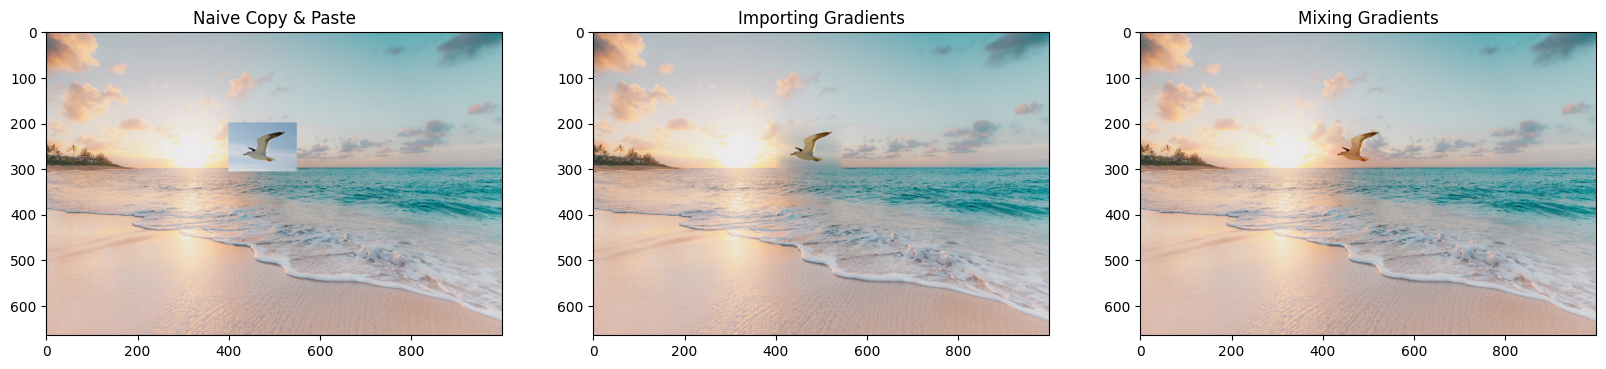

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(20, 15))

ax[0].imshow(res_naive_colour, cmap=plt.cm.gray)
ax[1].imshow(res_importing_colour, cmap=plt.cm.gray)
ax[2].imshow(res_mixing_colour, cmap=plt.cm.gray)

ax[0].set_title('Naive Copy & Paste')
ax[1].set_title('Importing Gradients')
ax[2].set_title('Mixing Gradients')

plt.show()

Save the images in the results folder.

In [25]:
mpimg.imsave("results/res_naive1.png", res_naive1, cmap=plt.cm.gray)
mpimg.imsave("results/res_importing1.png", res_importing1, cmap=plt.cm.gray)
mpimg.imsave("results/res_mixing1.png", res_mixing1, cmap=plt.cm.gray)

mpimg.imsave("results/res_naive2.png", res_naive2, cmap=plt.cm.gray)
mpimg.imsave("results/res_importing2.png", res_importing2, cmap=plt.cm.gray)
mpimg.imsave("results/res_mixing2.png", res_mixing2, cmap=plt.cm.gray)

mpimg.imsave("results/res_naive_colour.png", res_naive_colour)
mpimg.imsave("results/res_importing_colour.png", res_importing_colour)
mpimg.imsave("results/res_mixing_colour.png", res_mixing_colour)